In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import warnings
import glob
from PIL import Image, ImageDraw
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
# check out the file names within the directory

data = glob.glob('../RawData/csv/*')
data

['../RawData/csv\\bboxnames.csv',
 '../RawData/csv\\extra_images.csv',
 '../RawData/csv\\extra_images_2.csv',
 '../RawData/csv\\extra_labels.csv',
 '../RawData/csv\\extra_labels_2.csv',
 '../RawData/csv\\test_bboxes.csv',
 '../RawData/csv\\test_images.csv',
 '../RawData/csv\\test_images_2.csv',
 '../RawData/csv\\test_labels.csv',
 '../RawData/csv\\test_labels_2.csv',
 '../RawData/csv\\train_bboxes.csv',
 '../RawData/csv\\train_images.csv',
 '../RawData/csv\\train_images_2.csv',
 '../RawData/csv\\train_labels.csv',
 '../RawData/csv\\train_labels_2.csv']

In [3]:
train_images = pd.read_csv('../RawData/csv/train_images.csv')
train_images_2 = pd.read_csv('../RawData/csv/train_images_2.csv')
train_labels = pd.read_csv('../RawData/csv/train_labels.csv')
train_labels_2 = pd.read_csv('../RawData/csv/train_labels_2.csv')
test_images = pd.read_csv('../RawData/csv/test_images.csv')
test_labels = pd.read_csv('../RawData/csv/test_labels.csv')
extra_images = pd.read_csv('../RawData/csv/extra_images.csv')
extra_labels = pd.read_csv('../RawData/csv/extra_labels.csv')

In [4]:
train_images.head(3)

,filename,0,1,2,3,4,5,6,7,8,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,5502.png,0.352349,0.366906,0.373620,0.360278,0.330929,0.309424,0.293906,0.297059,0.304902,...,0.474878,0.470063,0.467549,0.470576,0.476565,0.470106,0.438710,0.421169,0.385192,0.345294
1,6876.png,0.754941,0.726082,0.680365,0.628380,0.572475,0.520447,0.486898,0.469718,0.449831,...,0.485941,0.496576,0.506486,0.513882,0.515012,0.508341,0.515290,0.526161,0.558259,0.578592
2,12741.png,0.180714,0.192925,0.204243,0.226600,0.233271,0.227729,0.225663,0.221294,0.218545,...,0.482420,0.495078,0.532439,0.593161,0.634722,0.678584,0.745933,0.725878,0.620443,0.527667


In [5]:
train_labels.head(3)

,filename,0,1,2,3,4
0,5502.png,10.0,10.0,10.0,3.0,5.0
1,6876.png,10.0,10.0,10.0,1.0,5.0
2,12741.png,10.0,10.0,10.0,2.0,9.0


In order to have the data work within the model the images will need to be changed to data type float32.

In [6]:
# convert all values in all rows and all columns beginning at column index 1 to float32

train_images = np.array(train_images.iloc[:,1:].astype('float32'))
train_labels = np.array(train_labels.iloc[:,1:].astype('float32'))

train_images_2 = np.array(train_images_2.iloc[:,1:].astype('float32'))
train_labels_2 = np.array(train_labels_2.iloc[:,1:].astype('float32'))

test_images = np.array(test_images.iloc[:,1:].astype('float32'))
test_labels = np.array(test_labels.iloc[:,1:].astype('float32'))

extra_images = np.array(extra_images.iloc[:,1:].astype('float32'))
extra_labels = np.array(extra_labels.iloc[:,1:].astype('float32'))

Label:  [10. 10. 10.  3.  5.]


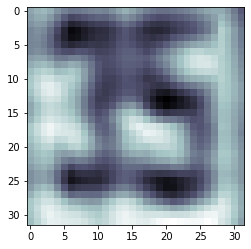

In [7]:
# plot an image to get a visual of what they look like

print('Label: ', train_labels[0])
plt.imshow(train_images[0].reshape(32,32), cmap=plt.cm.bone)

plt.show()

In [8]:
# define a function to create a binary matrix from the labels arrays

def digit_to_categorical(data):
    n = data.shape[1]
    data_cat = np.empty([len(data), n, 11])    
    for i in range(n):
        data_cat[:, i] = to_categorical(data[:, i], num_classes=11)        
    return data_cat

In [9]:
# concatenate and reshape the 2 training sets (images and labels)

img_train = np.concatenate((train_images.reshape(-1, 32, 32, 1),
                            train_images_2.reshape(-1, 32, 32, 1)),
                            axis=0)
lbl_train = np.concatenate((digit_to_categorical(train_labels),
                            digit_to_categorical(train_labels_2)),
                            axis=0)

In [10]:
# make extra images and labels the validation sets

img_valid = extra_images.reshape(-1, 32, 32, 1)
lbl_valid = digit_to_categorical(extra_labels)

In [11]:
# reshape and binarize the test sets

img_test = test_images.reshape(-1, 32, 32, 1)
lbl_test = digit_to_categorical(test_labels)

In [12]:
# check to ensure the image and label data are of the correct shape

print('Training images shape:  ', img_train.shape)
print('Validation images shape:', img_valid.shape)
print('Testing images shape:   ', img_test.shape)
print('Training labels shape:  ', lbl_train.shape)
print('Validation labels shape:', lbl_valid.shape)
print('Testing labels shape:   ', lbl_test.shape)

Training images shape:   (26000, 32, 32, 1)
Validation images shape: (13000, 32, 32, 1)
Testing images shape:    (6000, 32, 32, 1)
Training labels shape:   (26000, 5, 11)
Validation labels shape: (13000, 5, 11)
Testing labels shape:    (6000, 5, 11)


In [13]:
# convert label arrays into lists

lbl_train_list = [lbl_train[:, i] for i in range(5)]
lbl_test_list = [lbl_test[:, i] for i in range(5)]
lbl_valid_list = [lbl_valid[:, i] for i in range(5)]

# Keras Functional Model

In [14]:
def cnn_model():    
    model_input = Input(shape=(32, 32, 1))
    x = BatchNormalization()(model_input)
        
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(model_input)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.2)(x)
    
    #x = Conv2D(64, (3, 3), activation='relu')(x)
    #x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    
    #x = Conv2D(128, (3, 3), activation='relu')(x)
    #x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)
    
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    out = [Dense(11, activation='softmax')(x) for i in range(5)]
    
    model = Model(inputs=model_input, outputs=out)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [15]:
cnn_model = cnn_model()

In [16]:
e_brake = EarlyStopping(monitor='val_loss', patience=8)

In [17]:
cnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         conv2d_1[0][0]                   
______________________________________________________________________________________________

### Fit the model to the training and validation datasets

In [18]:
cnn_history = cnn_model.fit(img_train, lbl_train_list,
                            batch_size=128,
                            validation_data=(img_valid, lbl_valid_list),
                            epochs=100,
                            callbacks=[e_brake],
                            verbose=0)

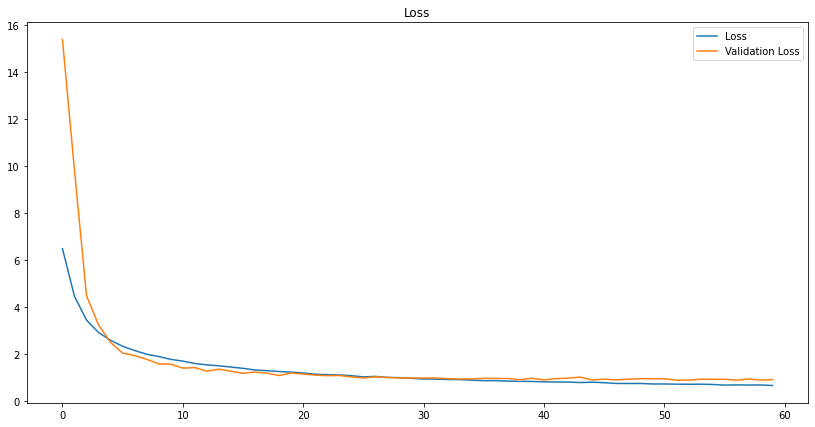

In [20]:
plt.figure(figsize=(14, 7))

plt.plot(cnn_history.history['loss'], label = 'Loss')
plt.plot(cnn_history.history['val_loss'], label = 'Validation Loss')

plt.legend()
plt.title('Loss')
plt.show()

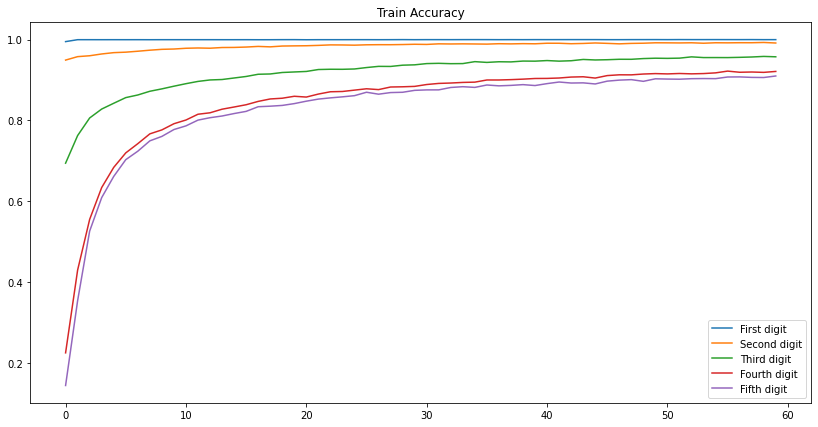

In [21]:
plt.figure(figsize=(14,7))

plt.plot(cnn_history.history['dense_1_accuracy'], label = 'First digit')
plt.plot(cnn_history.history['dense_2_accuracy'], label = 'Second digit')
plt.plot(cnn_history.history['dense_3_accuracy'], label = 'Third digit')
plt.plot(cnn_history.history['dense_4_accuracy'], label = 'Fourth digit')
plt.plot(cnn_history.history['dense_5_accuracy'], label = 'Fifth digit')

plt.legend()
plt.title('Train Accuracy')
plt.show()

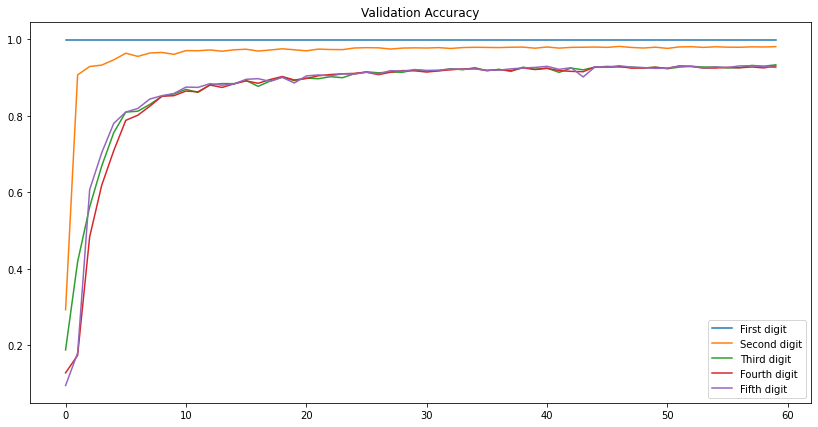

In [22]:
plt.figure(figsize=(14,7))

plt.plot(cnn_history.history['val_dense_1_accuracy'], label = 'First digit')
plt.plot(cnn_history.history['val_dense_2_accuracy'], label = 'Second digit')
plt.plot(cnn_history.history['val_dense_3_accuracy'], label = 'Third digit')
plt.plot(cnn_history.history['val_dense_4_accuracy'], label = 'Fourth digit')
plt.plot(cnn_history.history['val_dense_5_accuracy'], label = 'Fifth digit')

plt.legend()
plt.title('Validation Accuracy')
plt.show()

### Evaluate the model on the test datasets

In [23]:
test_scores = cnn_model.evaluate(img_test, lbl_test_list, verbose=0)

In [24]:
print('First digit accuracy: {:0.2f}%'.format(test_scores[6]*100))
print('Second digit accuracy: {:0.2f}%'.format(test_scores[7]*100))
print('Third digit accuracy: {:0.2f}%'.format(test_scores[8]*100))
print('Fourth digit accuracy: {:0.2f}%'.format(test_scores[9]*100))
print('Fifth digit accuracy: {:0.2f}%'.format(test_scores[10]*100))

First digit accuracy: 99.98%
Second digit accuracy: 99.58%
Third digit accuracy: 95.68%
Fourth digit accuracy: 91.02%
Fifth digit accuracy: 88.83%


In [25]:
print('Overall model accuracy: {:0.2f}%'.format((sum(test_scores[6:])/5)*100))

Overall model accuracy: 95.02%
